In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
# !pip install catboost

In [ ]:
# https://drive.google.com/file/d/1vBgq_hkXX4iJWpKsWqy8zZ35clF6Dtc-/view?usp=drive_link
!gdown --id 1sNeOcbGFzBRVThRrLTzhBmudeTCQ0--P
!gdown --id 1eDsWvpWB4abiwPf_ranwiCt8hMqZWX6-


In [ ]:
!unzip /content/data_phase-2.zip -d /content/captured_data/
!unzip /content/phase-2.zip -d /content/old_data/
!rm /content/phase-2.zip
!rm /content/data_phase-2.zip

# Load data

In [2]:
x_train = "/content/processed_data_x.parquet"
y_train = "/content/processed_data_y.parquet"
# captured_data = "/content/total_data.parquet"

X = pd.read_parquet(x_train)
y = pd.read_parquet(y_train)
# X_cap = pd.read_parquet(captured_data)


In [ ]:
print(X.info())
print(y.info())
# print(X_cap.info())

# t-SNE

In [19]:
#@title Define t-SNE plot and feature important using catboostfrom collections import Counter

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import catboost as cb
import re
from sklearn.cluster import DBSCAN
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

def under_sample_data(data):
    # Separate the input features and the target variable
    X = data.drop('label', axis=1)
    y = data['label']

    # Check the distribution of the target variable
    print("Original distribution of target: ", Counter(y))


    # Perform the under-sampling using RandomUnderSampler
    rus = RandomUnderSampler(sampling_strategy={1: 4000, 0: 4000})
    X_train_resampled, y_train_resampled = rus.fit_resample(X, y)

    # Check the distribution of the target variable after under-sampling
    print("Distribution after under-sampling: ", Counter(y_train_resampled))

    # Combine the under-sampled X and y into a DataFrame
    data_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
    data_resampled['label'] = y_train_resampled

    return data_resampled


def visualize_chart_and_feature(X, y):

    # # Plot t-SNE chart
    # df = under_sample_data(df)

    # df_x = df.drop("label", axis=1)
    # df_y = df["label"]

    # # Create a t-SNE model with two components
    # tsne_model = TSNE(n_components=2, random_state=0)

    # # Apply the model to your data DataFrame
    # tsne_data = tsne_model.fit_transform(df)

    # # Define the color for each label
    # colors = ["red", "blue" ]
    # labels= ['Fraud', 'No Fraud']
    # # Plot the results
    # fig, ax = plt.subplots()
    # for i in range(len(colors)):
    #     x = tsne_data[df_y == i, 0]
    #     y = tsne_data[df_y == i, 1]
    #     ax.scatter(x, y, c=colors[i], label=labels[i])

    # plt.xlabel('t-SNE Component 1')
    # plt.ylabel('t-SNE Component 2')
    # plt.title('t-SNE Visualization')
    # ax.legend()
    # plt.show()


    #Check feature important by using catboost

    # Fit a CatBoostClassifier model on the data

    df_x = X
    df_y = y
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify = y_train)

    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=500,
                                learning_rate=0.02,
                                depth=5,
                                eval_metric='AUC', 
                                silent=True)
                                

    # Fit model
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 50 )

    # model = cb.CatBoostClassifier(eval_metric = "AUC", silent=True)
    # model.fit(df_x, df_y)

    # Get the feature importances
    feature_importances = model.get_feature_importance()
    keys = df_x.columns
    importances_dict = {keys[i]: feature_importances[i] for i in range(len(keys))}
    importances_dict = dict(sorted(importances_dict.items(), key=lambda item: item[1]))

    # print(importances_dict)

    # # Create a color map with a different color for each feature
    colors = plt.cm.Set3(np.linspace(0, 1, len(df_x.columns)))

    print(len(colors), len(keys))

    # Create a bar plot of the feature importances
    plt.barh(np.arange(len(df_x.columns)), importances_dict.values(), color=colors)
    plt.yticks(np.arange(len(df_x.columns)), importances_dict.keys())
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()
    
    # Get predictions
    preds = model.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, preds)

    # Calculate the ROC AUC score
    auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    # Print the ROC AUC score
    print('ROC AUC score:', auc)
    print(classification_report(y_test, preds))
    print(cm)
    return importances_dict

## Show plot 

In [ ]:
%%time
#@title Before processed - Raw dataset

training_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-2/processed_data_x.parquet")
label = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-2/processed_data_y.parquet")
X = training_data #[selected_cols]
y = label
model_important_score = visualize_chart_and_feature(X, y)

As we can see here, it hard and may take more effort, even by human to distinguish "Fraud" and "No Fraud" data points.

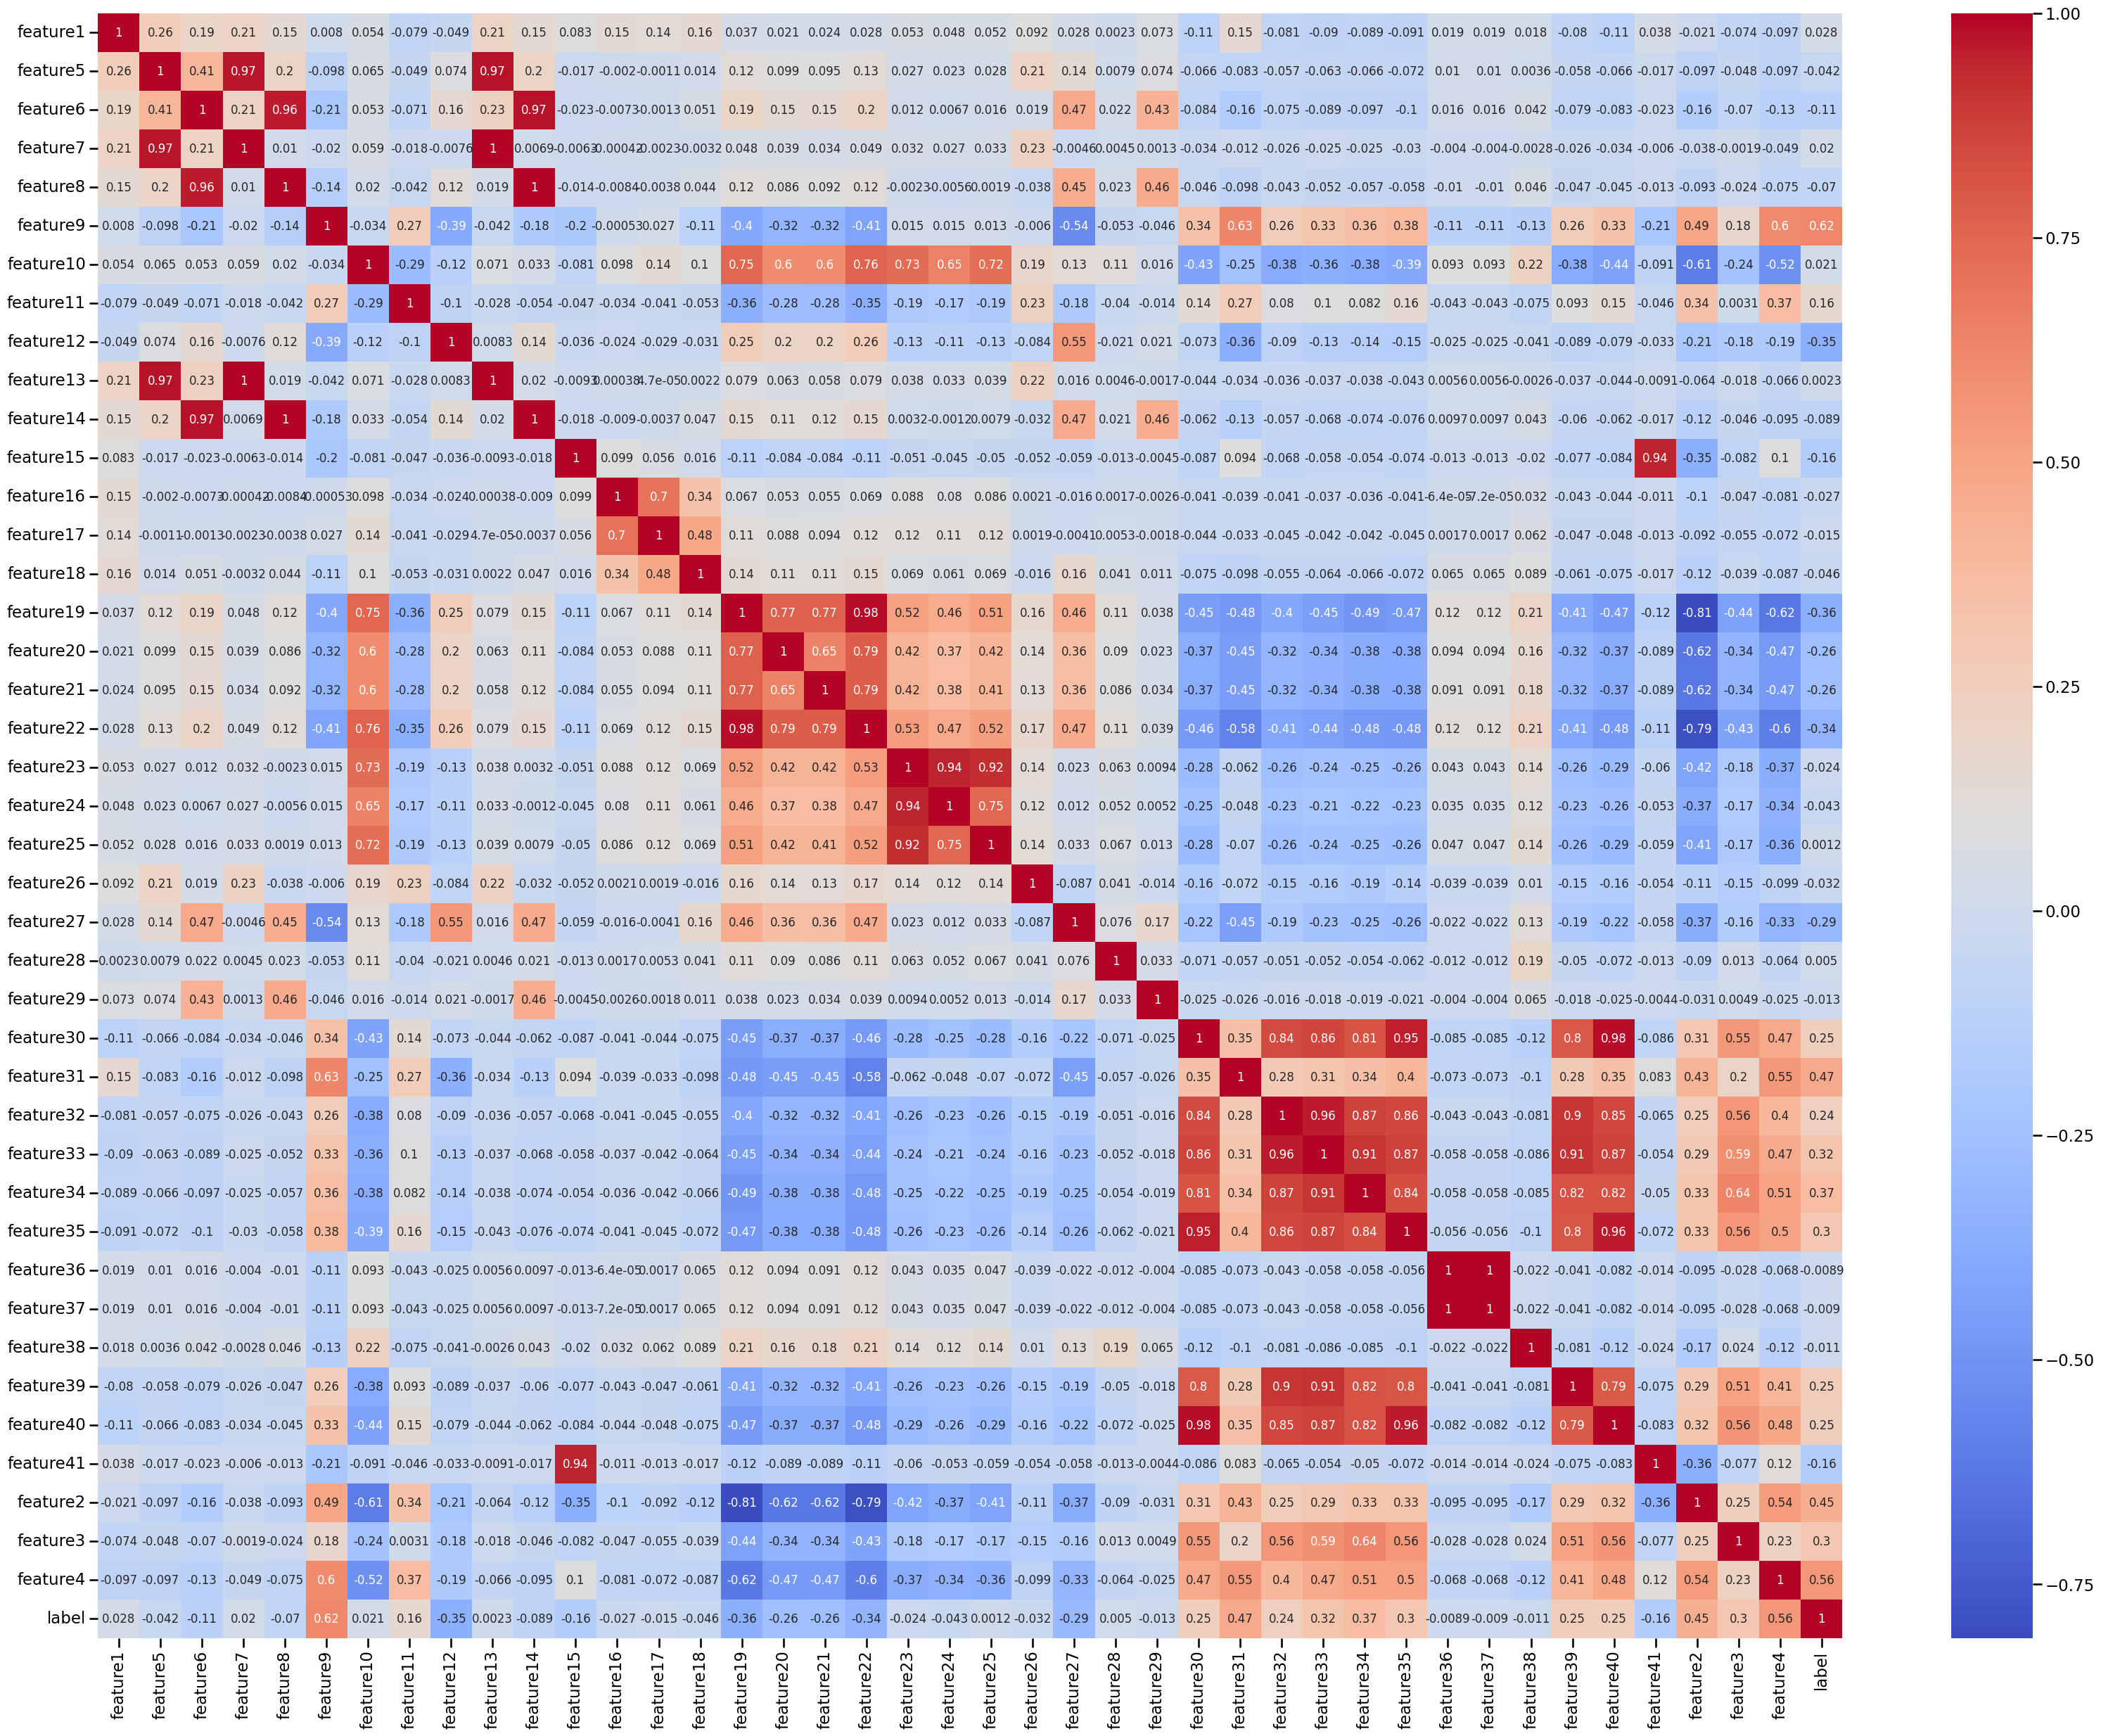

label        1.000000
feature9     0.622653
feature4     0.561283
feature31    0.473746
feature2     0.448070
feature34    0.371636
feature33    0.318157
feature3     0.301703
feature35    0.300623
feature39    0.251392
feature40    0.247575
feature30    0.247486
feature32    0.241229
feature11    0.163311
feature1     0.028060
feature10    0.021336
feature7     0.019807
feature28    0.004972
feature13    0.002324
feature25    0.001225
feature36   -0.008899
feature37   -0.009011
feature38   -0.011396
feature29   -0.013436
feature17   -0.014667
feature23   -0.023992
feature16   -0.026515
feature26   -0.032215
feature5    -0.041510
feature24   -0.042617
feature18   -0.045711
feature8    -0.070087
feature14   -0.089173
feature6    -0.112601
feature15   -0.156412
feature41   -0.161306
feature21   -0.260669
feature20   -0.264030
feature27   -0.294163
feature22   -0.335437
feature12   -0.351324
feature19   -0.361570
Name: label, dtype: float64

In [49]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

training_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_x.parquet")
label = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_y.parquet")

# Calculate the correlation matrix
corr_matrix = pd.concat([training_data, label], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(40,30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

corr_matrix['label'].sort_values(ascending=False)

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, f_classif, mutual_info_classif

# Load the dataset
training_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_x.parquet")
label = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_y.parquet")

def drop_features(training_data, label, score_metrix, k):
    # Get the target variable
    target = label.to_numpy().flatten()
    # Get the features
    features = training_data.to_numpy()

    print(target.shape, features.shape)

    # Create a feature selection object
    selector = SelectKBest(score_metrix, k=k)

    # Fit the selector to the data
    selector.fit(features, target)


    # Get the support array as a NumPy array
    support = selector.get_support().astype(np.bool_)

    selected_cols = [name for name, is_important in zip(training_data.columns, list(support)) if is_important]

    # Get the selected features
    selected_features = training_data[selected_cols]

    not_selected = []
    for name in training_data.columns:
        if name not in selected_cols:
            not_selected.append(name)
    # Print the selected features
    # print(selected_features.info())
    return not_selected


k = 30

drop_by_classif = drop_features(training_data, label, f_classif, k)

drop_by_mutual = drop_features(training_data, label, mutual_info_classif, k)

drop_by_model = list(model_important_score.keys())[:-k]

(92762,) (92762, 41)
(92762,) (92762, 41)


In [43]:
print(len(drop_by_classif), sorted(drop_by_classif, key = lambda x: int(x.strip('feature'))))
print(len(drop_by_mutual), sorted(drop_by_mutual, key = lambda x: int(x.strip('feature'))))
print(len(drop_by_model), sorted(drop_by_model, key = lambda x: int(x.strip('feature'))))

11 ['feature7', 'feature10', 'feature13', 'feature17', 'feature23', 'feature25', 'feature28', 'feature29', 'feature36', 'feature37', 'feature38']
11 ['feature3', 'feature20', 'feature21', 'feature22', 'feature28', 'feature29', 'feature36', 'feature37', 'feature38', 'feature39', 'feature41']
11 ['feature15', 'feature18', 'feature20', 'feature21', 'feature22', 'feature29', 'feature32', 'feature36', 'feature37', 'feature39', 'feature41']


In [44]:
# Merge the lists and remove duplicates
merged_list_drop = list(set(drop_by_classif + drop_by_mutual + drop_by_model))
print(len(merged_list_drop),"\n", merged_list_drop)

20 
 ['feature10', 'feature38', 'feature15', 'feature22', 'feature32', 'feature37', 'feature3', 'feature25', 'feature29', 'feature17', 'feature36', 'feature20', 'feature28', 'feature21', 'feature41', 'feature7', 'feature18', 'feature23', 'feature13', 'feature39']


In [45]:
# Find the intersection
intersection_list_drop = list(set(drop_by_classif) & set(drop_by_mutual) & set(drop_by_model))
print(len(intersection_list_drop),"\n", intersection_list_drop)


3 
 ['feature36', 'feature37', 'feature29']


In [ ]:
# Import the package
import nlcor

correlation_score = {}
for col in training_data.columns:
        
    # Assuming that x and y are your variables
    result = nlcor.nlcor(training_data[col], label)
    correlation_score[col] = result['cor_estimate']

sorted(correlation_score)

In [ ]:
#@title Feature Selection and Dimension Reduction

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

def select_features_using_mcc(y, y_hat, threshold):
    """
    Selects the features with MCC scores higher than the given threshold and plots a barh chart of MCC scores.

    Parameters:
    X: 2D array-like of shape (n_samples, n_features)
        The training input samples.
    y: 1D array-like of shape (n_samples,)
        The target values.
    threshold: float
        The threshold for selecting features.
    """
    n_features = X.shape[1]
    mcc_scores = []
    for i in range(n_features):
        mcc = matthews_corrcoef(y, y_hat)
        mcc_scores.append(mcc)

    # Select the features with MCC scores higher than the threshold
    selected_features = [i for i in range(n_features) if mcc_scores[i] > threshold]

    # Plot a barh chart of MCC scores
    plt.barh(range(n_features), mcc_scores)
    plt.yticks(range(n_features))
    plt.xlabel('MCC Score')
    plt.ylabel('Feature')
    plt.show()

    return selected_features



In [ ]:
#@title Test




from sklearn.cluster import DBSCAN
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named df with binary labels 0 for not fraud and 1 for fraud
training_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_x.parquet")
label = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_y.parquet")
X = training_data.drop(['feature9', 'feature4', 'feature2','feature19', 'feature22', 'feature3','feature10', 'feature20', 'feature21','feature30', 'feature40', 'feature35','feature39', 'feature32', 'feature31',], axis=1)
y = label

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.02,
                           depth=7,
                           eval_metric='AUC')

# Fit model
model.fit(X_train[:-10000], y_train[:-10000], eval_set = [(X_train[-10000:], y_train[-10000:])], verbose = 50 )

# Get predictions
preds = model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Calculate the AUC score
auc = roc_auc_score(y_test, preds)

print(f'AUC score {auc}')
print(cm)
print(classification_report(y_test, preds))



# Distribution

# Dirft

## Detect drift with evidently

In [3]:
%matplotlib inline
# !pip install evidently
from pathlib import Path
from tqdm import tqdm
import pandas as pd

In [34]:
captured_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/captured_data/phase-3/prob-2/processed/captured_x.parquet")
training_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-2/processed_data_x.parquet")

In [ ]:
print(captured_data.describe())
print(captured_data.info())
print(training_data.describe())
training_data.info()

## Data/Covariance Drift

In [35]:
%%time

import pandas as pd
from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
from evidently.calculations.stattests import psi_stat_test
from tqdm import tqdm

# Step 1 – Importing required Packages
# Importing Pandas to read our CSV dataset.

# Step 2 – Reading the Data
# Reading our UCI_Credit_Card dataset.

# num = int(len(training_data)*0.8)
old_data = training_data
new_data = captured_data

# stattest=psi_stat_test

# Step 3 – Creating a Data Drift report
# Create a Dashboard object and pass DataDriftTab as the parameter.
data_drift_report = Report(metrics=[
    DatasetDriftMetric(),
    DataDriftTable()
])

# Our Final Report
# The image below shows the final view of our Dashboard.
data_drift_report.run(current_data=new_data, reference_data=old_data, column_mapping=None)
data_drift_report.save_html("data_drift_report.html")
data_drift_report


CPU times: user 40.1 s, sys: 939 ms, total: 41.1 s
Wall time: 41.2 s


In [16]:
%%time
import numpy as np
from scipy.stats import entropy, wasserstein_distance, ks_2samp

# calculate the PSI
def psi(expected, actual, bins=10):
    expected_hist = np.histogram(expected, bins=bins, density=True)[0]
    actual_hist = np.histogram(actual, bins=bins, density=True)[0]
    psi_value = np.sum((actual_hist - expected_hist) * np.log(actual_hist / expected_hist))
    return psi_value


def compare_distributions(data1, data2):
    # calculate the KL divergence
    kl_divergence = 0 # entropy(np.histogram(data1, bins=10)[0], np.histogram(data2, bins=10)[0])

    # calculate the JS divergence
    # js_divergence = (entropy(np.histogram(data1, bins=10)[0], np.histogram((data1 + data2) / 2, bins=10)[0]) +
    #                  entropy(np.histogram(data2, bins=10)[0], np.histogram((data1 + data2) / 2, bins=10)[0])) / 2

    # calculate the Wasserstein distance
    wasserstein = wasserstein_distance(data1, data2)
    max_num = max(np.max(data1), np.max(data2))
    min_num = min(np.min(data1), np.min(data2))
    wasserstein = (wasserstein - min_num) / (max_num - min_num)



    psi_value = 0 #psi(data1, data2)

    # calculate the KS statistic
    ks_statistic, p_value = ks_2samp(data1, data2)

    # return kl_divergence, js_divergence, wasserstein, psi_value, ks_statistic, p_value
    return kl_divergence, wasserstein, psi_value, ks_statistic, p_value


def cal_drift_score(training_data, captured_data):
  # create two sample datasets
  drift_score = {}
  
  for column in training_data.columns:
    # print(f"==============================={column}===============================")
    # data1 = X[:-10000][column].to_numpy()
    # data2 = X[-10000:][column].to_numpy()

    data1 = training_data[column].to_numpy()
    data2 = captured_data[column].to_numpy()

    # compare the distributions of the two datasets
    kl_divergence, wasserstein, psi_value, ks_statistic, p_value = compare_distributions(data1, data2)

    # print(f'KL divergence: {kl_divergence}')
    # print(f'Wasserstein distance: {wasserstein}')
    # print(f'PSI: {psi_value}') 
    # print(f'KS statistic: {ks_statistic}, p-value: {p_value}')
    drift_score[column] = wasserstein

  sorted_drift_score = dict(sorted(drift_score.items(), key=lambda item: item[1], reverse=True))

  # print(sorted_drift_score)
  return sorted_drift_score

CPU times: user 891 µs, sys: 7.09 ms, total: 7.98 ms
Wall time: 15.8 ms


In [30]:
%%time
import os
import numpy as np
from skimage.filters import threshold_otsu

processed_path = "/mnt/e/mlops-marathon/new_mlops/data_warehouse/captured_data/phase-3/prob-2/processed"

file_names = [d for d in os.listdir(processed_path)
                if os.path.isfile(os.path.join(processed_path, d)) and d != "captured_x.parquet"
            ]
# print(file_names)
len(file_names)
ls_drift_score = []
num = 0 
for file in tqdm(file_names, ncols=100, desc ="Loading...", unit ="file"):

    batch_captured_data = pd.read_parquet(os.path.join(processed_path, file))

    ls_drift_score.append(cal_drift_score(training_data, batch_captured_data))
    num += 1
    if num ==100: break

Loading...:  42%|████████████████████▎                           | 99/234 [01:58<02:41,  1.20s/file]

CPU times: user 1min 37s, sys: 864 ms, total: 1min 38s
Wall time: 2min


In [36]:
cal_drift_score(training_data, captured_data)

{'feature9': 0.7029345238083715,
 'feature4': 0.5279062073284672,
 'feature2': 0.5030780220460558,
 'feature19': 0.474385295537757,
 'feature22': 0.4644470459469146,
 'feature3': 0.35236853613951274,
 'feature10': 0.3312670894572319,
 'feature20': 0.23433650840570933,
 'feature21': 0.23304032796086113,
 'feature31': 0.18631693795537116,
 'feature30': 0.14760912176010502,
 'feature40': 0.14590725374566507,
 'feature35': 0.13101244155156533,
 'feature39': 0.11250231778125809,
 'feature32': 0.10174305861157684,
 'feature26': 0.09160302903879428,
 'feature33': 0.08820829264020613,
 'feature34': 0.0866524546110516,
 'feature27': 0.08038321018142022,
 'feature12': 0.029393735847622535,
 'feature1': 0.020042038422007805,
 'feature15': 0.015410919956886926,
 'feature11': 0.01325807392401821,
 'feature23': 0.008727728848239996,
 'feature25': 0.0055252544463312795,
 'feature24': 0.004784418009731986,
 'feature38': 0.004248674126180805,
 'feature17': 0.0035837186057296765,
 'feature37': 0.0025938

In [32]:
import numpy as np
from skimage.filters import threshold_otsu

def get_drift_score(ls_drift_score, training_data):
    list_of_captured = []
    for col in training_data.columns:
        score_col = np.array([dict[col] for dict in ls_drift_score])
        threshold2 = threshold_otsu(score_col)
        num_drifted = sum(1 for dict in ls_drift_score if dict[col] > threshold2)
        score_col = sorted(score_col)
        num_88_89_90  = [score_col[88], score_col[89], score_col[90]]
        list_of_captured.append((col, threshold2, num_drifted, num_88_89_90))
    return list_of_captured

def percent_in_list(ls_drift_score, num_drifted):
    return (num_drifted / len(ls_drift_score)) * 100

list_of_captured = get_drift_score(ls_drift_score, training_data)
for col, threshold2, num_drifted, num_88_89_90 in sorted(list_of_captured, key=lambda tup: tup[2]):
    print(f'{col} - {threshold2} - {num_drifted} = {percent_in_list(ls_drift_score, num_drifted)} - {num_88_89_90}')

feature27 - 0.08038894869468147 - 16 = 16.0 - [0.08039326361141176, 0.08039326361141176, 0.08039326361141176]
feature23 - 0.008977856030578534 - 18 = 18.0 - [0.009224972711871985, 0.009224972711871985, 0.009224972711871985]
feature36 - 0.0026445811956312152 - 18 = 18.0 - [0.002644947044383422, 0.002644947044383422, 0.002644947044383422]
feature37 - 0.002647276264732798 - 18 = 18.0 - [0.0026476421134850048, 0.0026476421134850048, 0.0026476421134850048]
feature25 - 0.00589417599683471 - 20 = 20.0 - [0.006491478139433619, 0.006491478139433619, 0.006491478139433619]
feature2 - 0.4941211978314547 - 21 = 21.0 - [0.497363878876424, 0.497363878876424, 0.497363878876424]
feature19 - 0.47420495063089185 - 22 = 22.0 - [0.47422840344951933, 0.47422840344951933, 0.4742362465867742]
feature22 - 0.46426995219105954 - 22 = 22.0 - [0.4643012021910596, 0.4643012021910596, 0.4643012021910596]
feature12 - 0.02939373604881059 - 23 = 23.0 - [0.029393736217367294, 0.029393736217367294, 0.029393736217367294]


## Concept drift

In [ ]:
!pip install -U scikit-multiflow

In [ ]:
%%time

from skmultiflow.drift_detection import ADWIN
import numpy as np

old_data = data.drop(['label'], axis = 1)
new_data = captured_x[old_data.columns].reset_index()

# initialize ADWIN
adwin_13 = ADWIN()
adwin_15 = ADWIN()
adwin_14 = ADWIN()
adwin_10 = ADWIN()
adwin_16 = ADWIN()
adwin_1 = ADWIN()
adwin_11 = ADWIN()
adwin_12 = ADWIN()
adwin_3 = ADWIN()

# simulate a data stream with drift
data_stream = pd.concat([old_data, new_data], axis = 0).dropna()
# apply ADWIN to data stream


for idx, row in tqdm(old_data.iterrows()):
  adwin_13.add_element(row['feature13'])
  adwin_15.add_element(row['feature15'])
  adwin_14.add_element(row['feature14'])
  adwin_10.add_element(row['feature10'])
  adwin_16.add_element(row['feature16'])
  adwin_1.add_element(row['feature1'])
  adwin_11.add_element(row['feature11'])
  adwin_12.add_element(row['feature12'])
  adwin_3.add_element(row['feature3'])
  # if adwin_13.detected_change() or adwin_15.detected_change() or adwin_14.detected_change() or adwin_10.detected_change() or adwin_16.detected_change():
  #     driff_data.append(row)
      # print(f'Change detected at index {idx}, input value: {row}')




In [ ]:
%%time
driff_data = []
for idx, row in tqdm(new_data.iterrows()):

  adwin_13.add_element(row['feature13'])
  adwin_15.add_element(row['feature15'])
  adwin_14.add_element(row['feature14'])
  adwin_10.add_element(row['feature10'])
  adwin_16.add_element(row['feature16'])
  adwin_1.add_element(row['feature1'])
  adwin_11.add_element(row['feature11'])
  adwin_12.add_element(row['feature12'])
  adwin_3.add_element(row['feature3'])
  if adwin_13.detected_change() or adwin_15.detected_change() or adwin_14.detected_change() or adwin_10.detected_change() or adwin_16.detected_change() or adwin_1.detected_change() or adwin_11.detected_change() or adwin_12.detected_change() or adwin_3.detected_change():
      driff_data.append(row)


In [ ]:
driff_data_df = pd.DataFrame(driff_data)
driff_data_df.info()

# Impro drift with KLIEP Model

In [ ]:
import os
import glob
import time
import pickle
import logging
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
import catboost as cb
from scipy.stats import wasserstein_distance, ks_2samp
from adapt.instance_based import KLIEP
from imblearn.over_sampling import SMOTE
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split




captured_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/captured_data/phase-3/prob-1/processed/captured_x.parquet")
training_data = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_x.parquet")
training_label = pd.read_parquet("/mnt/e/mlops-marathon/new_mlops/data_warehouse/processed_data/phase-3/prob-1/processed_data_y.parquet")

# Assuming you have a DataFrame named df with binary labels 0 for not fraud and 1 for fraud
X = training_data #.drop(['feature9', 'feature3', 'feature2'], axis=1)
y = training_label

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10,
                           learning_rate=0.02,
                           depth=7,
                           eval_metric='AUC')

# Fit model
model.fit(X_train[:-10000], y_train[:-10000], eval_set = [(X_train[-10000:], y_train[-10000:])], verbose = 50 )

# Get predictions
preds = model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Calculate the AUC score
auc = roc_auc_score(y_test, preds)

print(f'AUC score {auc}')
print(cm)
print(classification_report(y_test, preds))


# Create a KLIEP model
KLIEP_model = KLIEP(estimator = model, Xt=captured_data, kernel="rbf", gamma=1., verbose=0, random_state=0)

# Fit the model to the source data
print(KLIEP_model.fit_weights(Xs=training_data, Xt=captured_data))

KLIEP_model.fit(X=training_data, y=training_label)


# Get predictions
preds = KLIEP_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Calculate the AUC score
auc = roc_auc_score(y_test, preds)

print(f'AUC score {auc}')
print(cm)
print(classification_report(y_test, preds))


# Check Null percentage

In [14]:
import pandas as pd
import os

def  load_all_file(root_path):
    # Get a list of all folders in the current directory
    folders = os.listdir(root_path)

    # Remove the folder name 'processed' from the list of folders
    processed_folder = 'processed'
    folders = [folder for folder in folders if folder != processed_folder]

    # Create a list of Parquet files in each folder
    parquet_files = []
    for folder in folders:
        parquet_files.extend([os.path.join(root_path, folder, file) for file in os.listdir(os.path.join(root_path, folder)) if file.endswith('.parquet')])

    # Merge all the Parquet files into one DataFrame
    df = pd.DataFrame()
    for parquet_file in parquet_files:
        df = df.append(pd.read_parquet(parquet_file))

    # Drop the duplicate rows
    df = df.drop_duplicates()

    # Save the DataFrame to a new Parquet file
    # df.to_parquet('processed.parquet')

    return df

In [9]:
phase_2 = "/mnt/e/mlops-marathon/new_mlops/data_warehouse/captured_data/phase-2/prob-2/"
pahse_3 = "/mnt/e/mlops-marathon/new_mlops/data_warehouse/captured_data/phase-3/prob-2/"

In [15]:
df = load_all_file(phase_2)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15221 entries, 0 to 1896
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature30  14336 non-null  float64
 1   feature6   14341 non-null  float64
 2   feature38  14342 non-null  float64
 3   feature24  14306 non-null  float64
 4   feature32  14356 non-null  float64
 5   feature11  14320 non-null  float64
 6   feature16  14337 non-null  float64
 7   feature39  14387 non-null  float64
 8   feature29  14380 non-null  float64
 9   feature7   14335 non-null  float64
 10  feature20  14324 non-null  float64
 11  feature15  14311 non-null  float64
 12  feature3   15221 non-null  object 
 13  feature17  14303 non-null  float64
 14  feature31  14303 non-null  float64
 15  feature34  14367 non-null  float64
 16  feature13  14334 non-null  float64
 17  feature27  14338 non-null  float64
 18  feature41  14370 non-null  float64
 19  feature5   14359 non-null  float64
 20  feature

In [17]:
df2 = load_all_file(pahse_3)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11048 entries, 0 to 999
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature15  11048 non-null  float64
 1   feature38  11048 non-null  float64
 2   feature24  11048 non-null  float64
 3   feature32  11048 non-null  float64
 4   feature27  11048 non-null  float64
 5   feature37  11048 non-null  float64
 6   feature23  11048 non-null  float64
 7   feature31  11048 non-null  float64
 8   feature14  11048 non-null  float64
 9   feature26  11048 non-null  float64
 10  feature16  11048 non-null  float64
 11  feature28  11048 non-null  float64
 12  feature22  11048 non-null  float64
 13  feature11  11048 non-null  float64
 14  feature17  11048 non-null  float64
 15  feature2   11048 non-null  object 
 16  feature33  11048 non-null  float64
 17  feature41  11048 non-null  float64
 18  feature34  11048 non-null  float64
 19  feature5   11048 non-null  float64
 20  feature4

In [18]:
import pandas as pd
import numpy as np


# Calculate the percentage of NaN or null values in each column
percentage_nan = (df2.isnull().sum() / df2.shape[0]) * 100

# Sort the columns by the percentage of NaN or null values in descending order
sorted_percentage_nan = percentage_nan.sort_values(ascending=False)

# Print the sorted percentage of NaN or null values
print(sorted_percentage_nan)

feature15    0.0
feature4     0.0
feature1     0.0
feature29    0.0
feature30    0.0
feature21    0.0
feature9     0.0
feature6     0.0
feature35    0.0
feature36    0.0
feature25    0.0
feature18    0.0
feature13    0.0
feature10    0.0
feature19    0.0
feature7     0.0
feature20    0.0
feature39    0.0
feature3     0.0
feature12    0.0
feature40    0.0
feature38    0.0
feature5     0.0
feature24    0.0
feature32    0.0
feature27    0.0
feature37    0.0
feature23    0.0
feature31    0.0
feature14    0.0
feature26    0.0
feature16    0.0
feature28    0.0
feature22    0.0
feature11    0.0
feature17    0.0
feature2     0.0
feature33    0.0
feature41    0.0
feature34    0.0
feature8     0.0
dtype: float64
